**Conservative Formula:**
**_Quantitative portfolio strategy using momentum, volatility, and dividend yield_**

## About This Project

This notebook implements the **Conservative Formula** - a quantitative investment strategy developed by **Pim van Vliet** and **David Blitz** at **Robeco**, published in:

> **Pim van Vliet & David Blitz (2018). The Conservative Formula: Quantitative Investing Made Easy.**  
> **Working Paper:** [SSRN link](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3145152)

This project is strictly **educational and analytical**, using public financial data to replicate and analyze the strategy’s performance.  
It does not constitute financial advice or investment recommendations.

## Strategy Overview

The **Conservative Formula** is a quantitative, rule-based strategy designed to outperform the market by selecting stocks with:

- High 12-month momentum (excluding the most recent month)  
- Low historical volatility  
- High dividend yield  

Originally introduced by **Robeco (2018)**, in this implementation the portfolio is rebalanced **quarterly** using transparent ranking filters.

## Data Loading and Preparation

In this first step, I prepare the dataset for the backtest.  
The focus is on the **S&P 500 universe**, as it provides a large, liquid, and well-documented set of stocks.

- Download monthly **close prices** and **dividends** from Yahoo Finance  
- Keep only stocks with sufficient history to ensure data quality  
- Construct clean monthly panels for both prices and dividends  
- Define a **quarterly rebalancing calendar** to be used later for portfolio updates  

This process produces a consistent dataset of S&P 500 stocks, ready for factor computation and portfolio construction.

In [1]:
# --- Configuration & Backtest Setup (S&P500) ---

import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
from dateutil.relativedelta import relativedelta
from typing import List, Dict
from tqdm.notebook import tqdm


UNIVERSE = "sp500"
YEARS_BACKTEST = 20

vol_lookback_months = 36            # 36-month volatility lookback
momentum_skip_months = 1            # 12–1 momentum: skip the most recent month

PRICE_FREQ = "1mo"
REBALANCE_MONTHS = [3, 6, 9, 12]    # quarterly rebalancing months
BATCH_SIZE = 80                     # safe batch size for Yahoo Finance API


today = datetime.today().date()
backtest_start = today - relativedelta(years=YEARS_BACKTEST)
data_start = backtest_start - relativedelta(months=vol_lookback_months + momentum_skip_months + 1)
data_end = today

print(f"Backtest window: {backtest_start} → {data_end} (data starts: {data_start})")

Backtest window: 2005-09-15 → 2025-09-15 (data starts: 2002-07-15)


In [2]:
# --- Load S&P 500 tickers ---

def load_tickers() -> List[str]:
    url = "https://datahub.io/core/s-and-p-500-companies/r/constituents.csv"
    df = pd.read_csv(url)
    tickers = (
        df["Symbol"]
        .astype(str)
        .str.strip()
        .str.replace(".", "-", regex=False)
        .tolist()
    )
    # Special case: BF.B -> BF-B
    tickers = ["BF-B" if t.upper() == "BF.B" else t for t in tickers]
    return sorted(set(tickers))

if UNIVERSE == "sp500":
    tickers = load_tickers()
else:
    raise ValueError("Unsupported UNIVERSE")

print(f"Universe size: {len(tickers)}")

Universe size: 503


In [3]:
# --- Helper functions (data download & panels) ---

def chunkify(lst: List[str], n: int) -> List[List[str]]:
    """Split a list of tickers into smaller chunks of maximum size n (used for batch downloads)."""
    
    return [lst[i:i+n] for i in range(0, len(lst), n)]


def download_batch(symbols: List[str]) -> Dict[str, pd.DataFrame]:
    """
    Download OHLCV data + dividends for a batch of symbols from Yahoo Finance.
    Returns a dictionary {ticker -> DataFrame} with separate 'Dividends' columns.
    """

    df = yf.download(
        symbols,
        start=data_start,
        end=data_end,
        interval=PRICE_FREQ,
        group_by="ticker",
        auto_adjust=False,          
        actions=True,
        threads=True,
        progress=False,
    )
    out = {}
    if isinstance(df.columns, pd.MultiIndex):
        for t in symbols:
            if t in df.columns.get_level_values(0):
                out[t] = df[t].copy()
    else:                           
        out[symbols[0]] = df.copy()    # single ticker case
        
    return out


def build_close_panel(raw_dict: Dict[str, pd.DataFrame]) -> pd.DataFrame:
    """Build a monthly Close price panel from raw Yahoo Finance data."""
    
    frames = [df["Close"].rename(t) for t, df in raw_dict.items() if "Close" in df]
    if not frames:
        return pd.DataFrame()
    
    out = pd.concat(frames, axis=1)
    out.index = pd.to_datetime(out.index).to_period("M").to_timestamp("M")
    
    return out.dropna(axis=1, thresh=int(len(out) * 0.7)).ffill().bfill()


def build_div_panel(raw_dict: Dict[str, pd.DataFrame]) -> pd.DataFrame:
    """Build a monthly Dividends panel from raw Yahoo Finance data."""
    
    frames = [df["Dividends"].rename(t) for t, df in raw_dict.items() if "Dividends" in df]
    if not frames:
        return pd.DataFrame()
    
    out = pd.concat(frames, axis=1).fillna(0.0)
    out.index = pd.to_datetime(out.index).to_period("M").to_timestamp("M")
    
    return out

In [4]:
# --- Main pipeline (data loading) ---

def load_market_data(tickers: List[str], batch_size: int = BATCH_SIZE) -> Dict[str, pd.DataFrame]:
    """
    Load and prepare monthly Close prices and Dividends for a universe of tickers.
    Data is downloaded in batches and organized into clean panels.

    Returns a dictionary with:
        - monthly_close     : DataFrame of monthly Close prices
        - monthly_dividends : DataFrame of monthly Dividends
        - universe          : List of tickers with valid data
    """
    
    print("Downloading monthly OHLCV data + dividends (batched)...")
    
    raw_data_store, failed = {}, []
    batches = chunkify(tickers, batch_size)

    for batch in tqdm(batches, desc="Downloading batches", unit="batch"):
        try:
            dct = download_batch(batch)
            raw_data_store.update(dct)
        except Exception as e:
            print(f"Batch failed: {e}")
            failed.extend(batch)

    if failed:
        print(f"⚠ Missing data for {len(failed)} tickers (first 10): {failed[:10]}")

    monthly_close = build_close_panel(raw_data_store)
    monthly_dividends = build_div_panel(raw_data_store)

    if monthly_close.empty:
        raise RuntimeError("No price data retrieved. Check internet access or reduce tickers.")

    return {
        "monthly_close": monthly_close,
        "monthly_dividends": monthly_dividends,
        "universe": monthly_close.columns.tolist(),
    }

In [5]:
# --- Run pipeline & context setup ---

data_ctx = load_market_data(tickers)

# Add metadata to context (dates, parameters)
data_ctx.update({
    "backtest_start": backtest_start,
    "data_start": data_start,
    "data_end": data_end,
    "rebalance_dates": data_ctx["monthly_close"].index[
        (data_ctx["monthly_close"].index.month.isin(REBALANCE_MONTHS)) &
        (data_ctx["monthly_close"].index >= pd.Timestamp(backtest_start))
    ],
    "vol_lookback_months": vol_lookback_months,
    "momentum_skip_months": momentum_skip_months,
})

print(f"Price panel shape: {data_ctx['monthly_close'].shape}")
print(f"Dividends panel shape: {data_ctx['monthly_dividends'].shape}")
print(f"Final universe size: {len(data_ctx['universe'])}")

dates = data_ctx['rebalance_dates'][:4]
print("Rebalance dates (first 4):", [d.strftime("%Y-%m-%d") for d in dates])

Price panel shape: (278, 423)
Dividends panel shape: (278, 503)
Final universe size: 423
Rebalance dates (first 4): ['2005-09-30', '2005-12-31', '2006-03-31', '2006-06-30']


## Factor Construction

In this step, I compute the three building blocks of the **Conservative Formula** (Van Vliet & Blitz, 2018):

1. **Volatility**  
   - Calculated as the 36-month rolling standard deviation of monthly returns.  

2. **Momentum**  
   - Computed as the 12-month return excluding the most recent month (12–1 momentum).  

3. **Net Payout Yield (NPY)**  
   - Approximated by trailing 12-month dividend yield (DY_TTM).  
   - Defined as the sum of dividends paid over the last 12 months divided by the stock price.  
   - Buyback data is not included due to data limitations, so NPY is proxied by DY_TTM.  

These three factors form the basis for selecting the **100 most conservative stocks** in the portfolio construction step.

In [6]:
# --- Factor construction (Volatility, Momentum, Dividend Yield proxy for NPY) ---
import warnings

# Suppress irrelevant warnings for cleaner notebook output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Extract data from context
monthly_close  = data_ctx["monthly_close"]           
monthly_dividends = data_ctx["monthly_dividends"]

ME_INDEX = monthly_close.index

In [7]:
# ---------- Factor 1: Volatility ----------
def compute_volatility(returns: pd.DataFrame, lookback: int) -> pd.DataFrame:
    """Rolling volatility (std dev of monthly returns) over a lookback window in months."""

    return returns.rolling(window=lookback).std()

monthly_returns = monthly_close.pct_change()
volatility_36m = compute_volatility(monthly_returns, data_ctx["vol_lookback_months"])


# ---------- Factor 2: Momentum ----------
def compute_momentum(prices: pd.DataFrame, skip_months: int, lookback: int = 12) -> pd.DataFrame:
    """12-1 momentum: return over past 12 months, skipping most recent N months."""

    return (prices.shift(skip_months) / prices.shift(lookback + skip_months)) - 1

momentum = compute_momentum(monthly_close, data_ctx["momentum_skip_months"])

In [8]:
# ---------- Factor 3: Net Payout Yield (Dividend Yield approximation) ----------
class NPYDividendYieldProvider:
    """
    Net Payout Yield provider based on trailing 12-month dividend yield (DY_TTM).
    Formula:
        DY_TTM(t) = sum(dividends over last 12 months) / Price_t
    """
    
    def __init__(self, price_panel: pd.DataFrame, div_panel: pd.DataFrame):
        self.monthly_close  = price_panel
        self.monthly_dividends = div_panel
        self._last_coverage = None


    def compute_npy(self, date_ts: pd.Timestamp, tickers: list) -> pd.Series:
        """Compute trailing 12-month dividend yield (DY_TTM) for given tickers at month-end."""

        dt = pd.Timestamp(date_ts).to_period("M").to_timestamp("M")
        start_12 = (dt.to_period("M") - 11).to_timestamp("M")

        vals, has_div = {}, {}
        for t in tickers:
            # Dividends TTM
            div_ttm = self.monthly_dividends[t].loc[start_12:dt].sum(min_count=1) if t in self.monthly_dividends else 0.0
            # Price at date
            try:
                px_t = float(self.monthly_close.at[dt, t])
                dy = div_ttm / px_t if (px_t > 0 and np.isfinite(px_t)) else 0.0
            except Exception:
                dy = 0.0
            vals[t] = dy
            has_div[t] = div_ttm > 0

        self._last_coverage = pd.DataFrame({"has_div": pd.Series(has_div)}).reindex(tickers)
        
        return pd.Series(vals, index=tickers, dtype=float).fillna(0.0)


    def get_last_coverage(self) -> pd.DataFrame:
        """Return coverage info from the last call to compute_npy()."""
        
        return self._last_coverage.copy() if self._last_coverage is not None else pd.DataFrame()


NPY_PROVIDER_DY = NPYDividendYieldProvider(monthly_close, monthly_dividends)

In [9]:
# --- Add factors to data context ---

data_ctx.update({
    "monthly_returns": monthly_returns,
    "volatility_36m": volatility_36m,
    "momentum": momentum,
    "npy_provider": NPY_PROVIDER_DY,
})

print("Factors ready: volatility, momentum, and NPY provider added to context.")
print(f"Shapes -> volatility: {volatility_36m.shape}, momentum: {momentum.shape}, dividends: {monthly_dividends.shape}")

Factors ready: volatility, momentum, and NPY provider added to context.
Shapes -> volatility: (278, 423), momentum: (278, 423), dividends: (278, 503)


## Portfolio Selection

This step constructs the actual **Conservative Formula portfolio**, following the methodology of Van Vliet & Blitz (2018).  
The process is applied at each quarterly rebalance date and consists of four stages:

1. **Low-Volatility Screen**  
   - Select the 500 stocks with the lowest 36-month volatility.  

2. **Factor Ranks**  
   - For these candidates, compute two signals:  
     - **Momentum (12–1)** - past one-year return excluding the most recent month.  
     - **Net Payout Yield (NPY)** - approximated by trailing 12-month dividend yield (DY).  
       *Note: In the original research, NPY includes both dividends and net buybacks. Due to data limitations in Yahoo Finance, this implementation uses dividend yield only.*  

3. **Average Rank and Selection**  
   - Average the two factor ranks.  
   - Select the top 100 stocks based on the combined score.  

4. **Equal Weights**  
   - Assign equal weights to the 100 selected stocks (1/100 each, rebalanced quarterly).

This systematic, rules-based procedure produces a transparent portfolio that reflects the Conservative Formula investment style.


In [10]:
# --- Portfolio Selection Setup ---

LOWVOL_COUNT = 500
PORT_COUNT = 100     # final portfolio size (equal-weighted)

monthly_close = data_ctx["monthly_close"]
rebalance_dates = data_ctx["rebalance_dates"]
volatility_36m = data_ctx["volatility_36m"]
momentum = data_ctx["momentum"]

NPY_PROVIDER = data_ctx["npy_provider"]

In [11]:
def select_portfolio(dt: pd.Timestamp):
    """
    Select portfolio at a given rebalance date.
    Steps:
    1. Keep the 500 lowest-volatility stocks.
    2. Rank them by Momentum (12-1) and NPY.
    3. Average the ranks and select the top 100.
    4. Return equal weights and a diagnostics DataFrame.
    """

    if dt not in volatility_36m.index:
        return pd.Series(dtype=float), pd.DataFrame()

    # 1) Low-volatility screen
    vol_row = volatility_36m.loc[dt].dropna()
    candidates = vol_row.nsmallest(min(LOWVOL_COUNT, len(vol_row))).index
    if candidates.empty:
        return pd.Series(dtype=float), pd.DataFrame()

    # 2) Factors: Momentum & NPY
    mom_row = momentum.loc[dt].reindex(candidates) if dt in momentum.index else pd.Series(index=candidates, dtype=float)
    try:
        npy_row = NPY_PROVIDER.compute_npy(dt, candidates).reindex(candidates)
    except Exception:
        npy_row = pd.Series(index=candidates, dtype=float)

    # Require at least one valid signal
    valid_signals = ~(mom_row.isna() & npy_row.isna())
    if valid_signals.sum() == 0:
        return pd.Series(dtype=float), pd.DataFrame()

    # 3) Rankings
    mom_rank = mom_row[valid_signals].rank(ascending=False, na_option="bottom")
    npy_rank = npy_row[valid_signals].rank(ascending=False, na_option="bottom")
    avg_rank = (mom_rank + npy_rank) / 2

    # Select top 100 equal-weighted
    top_n = min(PORT_COUNT, avg_rank.notna().sum())
    top_names = avg_rank.nsmallest(top_n).index
    weights = pd.Series(1.0 / top_n, index=top_names, name=dt)


    diagnostics = pd.DataFrame({
        "volatility_36m": vol_row.reindex(avg_rank.index),
        "momentum": mom_row[valid_signals],
        "npy": npy_row[valid_signals],
        "mom_rank": mom_rank,
        "npy_rank": npy_rank,
        "avg_rank": avg_rank,
    }).sort_values("avg_rank", ascending=True)

    return weights, diagnostics

In [12]:
# Run selection for all rebalance dates
weights_by_date, diags_by_date, candidate_sizes = {}, {}, {}

for dt in rebalance_dates:
    weights, diag = select_portfolio(dt)
    if not weights.empty:
        weights_by_date[dt] = weights
        diags_by_date[dt]   = diag
        candidate_sizes[dt] = diag.shape[0]
    else:
        candidate_sizes[dt] = 0

print(f"Selections done for {len(weights_by_date)} / {len(rebalance_dates)} rebalance dates.")
if weights_by_date:
    first_dt = sorted(weights_by_date.keys())[0]
    print(f"Example selection at {first_dt.date()}: {len(weights_by_date[first_dt])} stocks")
    print("Top 5 tickers:", ", ".join(weights_by_date[first_dt].index[:5]))

    
# Save selection in context
data_ctx["selection"] = {
    "weights_by_date": weights_by_date,
    "diags_by_date": diags_by_date,
    "rebalance_dates": rebalance_dates,
}

Selections done for 81 / 81 rebalance dates.
Example selection at 2005-09-30: 100 stocks
Top 5 tickers: DLR, PEG, MO, DUK, EIX


## Factor Diagnostics

Before combining the factors into portfolio selection, I perform diagnostics to better understand their behavior:

1. **Coverage**  
   - Measures coverage of dividend yield (DY) data across the universe.
   - In this implementation, NPY is approximated by dividend yield only (buyback data not available).


2. **Correlation**  
   - Computes the correlation between Momentum and NPY.  
   - A low or negative correlation indicates that the factors provide complementary information.

3. **Inspection of Factor Values**  
   - Shows sample values of Momentum and NPY for individual stocks at the rebalance date.
   - Provides descriptive statistics of NPY distribution across the universe.

4. **Visualization**  
   - A scatter plot of NPY vs Momentum highlights the coverage and relationship between the two factors.

These diagnostics confirm that the factors capture different aspects of stock characteristics, supporting their combined use in the Conservative Formula strategy.

In [13]:
# --- Factor Diagnostics: MOM vs NPY ---

rebalance_date = sorted(diags_by_date.keys())[0]
diag = diags_by_date[rebalance_date]

# Coverage & correlation
has_npy = diag["npy"].notna() & (diag["npy"] != 0)
coverage = has_npy.mean()
corr_mom_npy = np.corrcoef(
    diag["momentum"].fillna(0).values,
    diag["npy"].fillna(0).values
)[0, 1]

# Summary header
summary = pd.DataFrame({
    "Dividend coverage": [f"{coverage:.1%}"],
    "Corr(MOM, NPY)": [f"{corr_mom_npy:.3f}"]
}, index=[rebalance_date.date()])

display(summary)

# Sample MOM vs NPY
display(diag[["momentum", "npy"]].head(10).style.format("{:.3f}"))

# NPY descriptive stats
display(diag["npy"].describe().to_frame("NPY").T.style.format("{:.3f}"))

,Dividend coverage,"Corr(MOM, NPY)"
2005-09-30,66.9%,-0.237


,momentum,npy
DLR,0.585,0.049
PEG,0.525,0.035
MO,0.444,0.041
DUK,0.309,0.060
EIX,0.675,0.021
BEN,0.510,0.029
BXP,0.282,0.073
EXC,0.462,0.030
OKE,0.443,0.031
SPG,0.360,0.037


,count,mean,std,min,25%,50%,75%,max
NPY,423.000,0.014,0.016,0.000,0.000,0.009,0.021,0.129


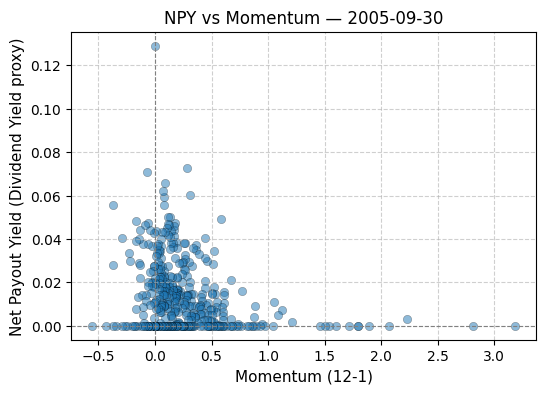

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
x = diag["momentum"].astype(float)
y = diag["npy"].astype(float)

plt.scatter(x, y, alpha=0.5, c="tab:blue", edgecolors="k", linewidth=0.3)

plt.axhline(0, color="gray", linewidth=0.8, linestyle="--")
plt.axvline(0, color="gray", linewidth=0.8, linestyle="--")

plt.xlabel("Momentum (12-1)", fontsize=11)
plt.ylabel("Net Payout Yield (Dividend Yield proxy)", fontsize=11)
plt.title(f"NPY vs Momentum — {rebalance_date.date()}", fontsize=12)

plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

## Backtest: Portfolio Construction and Performance

In this step, I simulate the performance of the **Conservative Formula portfolio**.  
The backtest follows a transparent and rules-based approach:

1. **Total Return Calculation**  
   - Monthly returns include both price changes and dividends.  

2. **Portfolio Simulation**  
   - Track portfolio weights through time.  
   - Holdings drift with returns until the next rebalance.  
   - At each quarterly rebalance, weights are reset to equal allocation.

3. **Transaction Costs**  
   - 30 bps transaction costs are applied on portfolio turnover at each rebalance.  
   - The initial portfolio build is exempt, following standard backtest convention.

4. **Performance Metrics**  
   - Calculate annualized CAGR, volatility, Sharpe ratio, maximum drawdown, and average turnover.  
   - These metrics provide a comprehensive view of the portfolio’s risk and return profile.  

This backtest brings the strategy to life, showing how the Conservative Formula would have performed historically under realistic conditions.

In [15]:
# --- Backtest configuration and context ---

monthly_close = data_ctx["monthly_close"]
monthly_dividends = data_ctx["monthly_dividends"]
rebalance_dates = data_ctx["selection"]["rebalance_dates"]
weights_by_date = data_ctx["selection"]["weights_by_date"]

TC_BPS = 30   # transaction cost per trade at rebalance (30 bps = 0.30%)
RF = 0.0      # risk-free rate (annualized, used for Sharpe ratio)

In [16]:
# --- Helper functions ---

def normalize_weights(w: pd.Series) -> pd.Series:
    """Normalize weights to sum to 1."""
    
    w = w.dropna()
    return w / w.sum() if w.sum() else pd.Series(dtype=float)


def max_drawdown(nav: pd.Series):
    """Compute maximum drawdown from a NAV time series."""
    
    peak = nav.cummax()
    drawdowns = nav / peak - 1.0
    maximum_drawdown_value = drawdowns.min()
    end = drawdowns.idxmin()
    start = nav.loc[:end].idxmax()
    
    return float(maximum_drawdown_value), start, end


# --- Total return calculation (capital gains + dividends) ---
total_return_monthly = ((monthly_close + monthly_dividends) / monthly_close.shift(1) - 1).replace([np.inf, -np.inf], np.nan)

In [17]:
# --- Backtest simulation (portfolio returns over time) ---

all_month_ends = total_return_monthly.index.sort_values()
first_reb_dt = rebalance_dates[0]
start_idx = all_month_ends.get_indexer([first_reb_dt])[0]
path_dates = all_month_ends[start_idx:]

holdings = pd.Series(dtype=float)
portfolio_returns = pd.Series(index=path_dates, dtype=float)
turnover_series = pd.Series(index=rebalance_dates, dtype=float).fillna(0.0)

for dt in path_dates:
    returns_row = total_return_monthly.loc[dt].astype(float)

    # 1) Realized return from previous holdings
    if not holdings.empty:
        active_weights = holdings.reindex(returns_row.index).fillna(0.0)
        mask = (active_weights != 0.0) & returns_row.notna()
        gross_return = (normalize_weights(active_weights[mask]) * returns_row[mask]).sum() if mask.any() else 0.0
    else:
        gross_return = 0.0

    # 2) Drift holdings
    if not holdings.empty:
        returns_on_holdings = returns_row.reindex(holdings.index).fillna(0.0)
        holdings = normalize_weights(holdings * (1.0 + returns_on_holdings))

    # 3) Rebalance if date matches
    transaction_cost = 0.0
    if dt in weights_by_date:
        target_w = weights_by_date[dt].copy()
        union_names = sorted(set(holdings.index) | set(target_w.index))
        current_weights, target_weights = holdings.reindex(union_names).fillna(0.0), target_w.reindex(union_names).fillna(0.0)

        delta = (target_weights - current_weights).abs()
        turnover = 0.5 * float(delta.sum())
        turnover_series.loc[dt] = turnover

        if not (holdings.empty and dt == first_reb_dt):
            transaction_cost = (TC_BPS / 10000.0) * turnover

        holdings = target_weights.copy()

    # Net monthly return
    portfolio_returns.loc[dt] = gross_return - transaction_cost

In [18]:
# --- Performance metrics ---

portfolio_nav = (1.0 + portfolio_returns.fillna(0.0)).cumprod()
num_months = portfolio_returns.dropna().shape[0]
years = num_months / 12.0 if num_months else 0.0

cagr_annual = (portfolio_nav.iloc[-1] ** (1 / years) - 1) if years > 0 else np.nan
annual_volatility = portfolio_returns.std(ddof=0) * (12 ** 0.5)

# Annualized Sharpe ratio
sharpe_ratio = ((portfolio_returns.mean() * 12 - RF) / annual_volatility) if annual_volatility else np.nan

max_drawdown_value, mdd_start, mdd_end = max_drawdown(portfolio_nav)
average_quarterly_turnover = turnover_series.mean() if len(turnover_series) else 0.0

print("Backtest complete.")
print(f"Months:       {num_months}")
print(f"CAGR Annual:   {cagr_annual:.2%}")
print(f"Vol:           {annual_volatility:.2%}")
print(f"Sharpe ratio:   {sharpe_ratio:.2f}")
print(f"MaxDD:        {max_drawdown_value:.2%} (from {mdd_start.date()} to {mdd_end.date()})")
print(f"Avg quarterly turnover: {average_quarterly_turnover:.2%}")
print(f"Transaction cost (bps): {TC_BPS}")

Backtest complete.
Months:       241
CAGR Annual:   11.04%
Vol:           14.56%
Sharpe ratio:   0.80
MaxDD:        -46.75% (from 2007-10-31 to 2009-02-28)
Avg quarterly turnover: 33.76%
Transaction cost (bps): 30


In [19]:
# --- Save backtest results to context ---
data_ctx.update({
    "port_monthly_returns": portfolio_returns,
    "portfolio_nav_monthly": portfolio_nav,
    "portfolio_turnover_quarterly": turnover_series,
    "tc_bps": TC_BPS,
})

## Benchmark Comparison

In this step, I compare the performance of the **Conservative Formula portfolio** against major U.S. equity benchmarks:

- **SPY** - S&P 500 ETF (large-cap benchmark)
- **IWM** - Russell 2000 ETF (small-cap benchmark)

For each benchmark, I compute monthly total returns (including dividends) and align them with the portfolio.  
I then calculate annualized performance metrics:

- **CAGR** - Compound Annual Growth Rate  
- **Volatility** - annualized standard deviation of returns  
- **Sharpe Ratio** - return per unit of risk (computed with RF = 0, following standard backtest convention)  
- **Max Drawdown** - largest peak-to-trough decline in portfolio value  

Finally, I compare cumulative NAVs (Net Asset Values) of the portfolio and benchmarks side by side.  
This step provides a clear benchmark context, showing whether the strategy adds value compared to broad market indices.

In [20]:
# --- Benchmark config & context ---

benchmark_tickers = ["SPY", "IWM"]    # S&P500, Russell2000

portfolio_returns = data_ctx["port_monthly_returns"].copy()
portfolio_nav = data_ctx["portfolio_nav_monthly"].copy()


benchmark_prices = yf.download(
    benchmark_tickers,
    start=portfolio_returns.index.min(),
    end=portfolio_returns.index.max() + pd.offsets.MonthEnd(1),
    interval="1mo",
    auto_adjust=True,   #  includes dividends
    progress=False
)["Close"]

# Align to month-end
benchmark_prices.index = pd.to_datetime(benchmark_prices.index).to_period("M").to_timestamp("M")
benchmark_returns_monthly = benchmark_prices.pct_change().dropna(how="all")
benchmark_navs = (1.0 + benchmark_returns_monthly.fillna(0.0)).cumprod()

# Align with portfolio
benchmark_returns_monthly = benchmark_returns_monthly.reindex(portfolio_returns.index).fillna(0.0)
benchmark_navs = benchmark_navs.reindex(portfolio_returns.index).ffill()

data_ctx["benchmark_navs"] = benchmark_navs

In [21]:
# --- Metrics helper ---

def compute_performance_metrics(returns: pd.Series, risk_free: float = 0.0):
    """Compute CAGR, Volatility, Sharpe, Max Drawdown from a return series."""
    
    returns = pd.Series(returns).dropna()
    if returns.empty:
        return {"CAGR": np.nan, "Vol": np.nan, "Sharpe": np.nan, "MaxDD": np.nan}
    
    nav = (1 + returns).cumprod()
    months = len(returns)
    years = months / 12
    
    cagr = nav.iloc[-1] ** (1/years) - 1 if years > 0 else np.nan
    volatility = returns.std(ddof=0) * (12**0.5)
    sharpe_ratio = ((returns.mean() * 12) - risk_free) / volatility if np.isfinite(volatility) and volatility != 0 else np.nan
    
    dd = nav / nav.cummax() - 1.0
    max_drawdown_value = dd.min()
    
    return {"CAGR": cagr, "Vol": volatility, "Sharpe": sharpe_ratio, "MaxDD": max_drawdown_value}

In [22]:
# --- Summary metrics (Portfolio vs Benchmarks) ---

metrics_table = {"Portfolio": compute_performance_metrics(portfolio_returns)}
for symbol in benchmark_tickers:
    metrics_table[symbol] = compute_performance_metrics(benchmark_returns_monthly[symbol])

metrics_comparison_df = pd.DataFrame(metrics_table).T

print("Benchmark comparison (monthly returns - annualized):")
display(metrics_comparison_df.style.format({
    "CAGR": "{:.2%}", "Vol": "{:.2%}", "Sharpe": "{:.2f}", "MaxDD": "{:.2%}"
}))

Benchmark comparison (monthly returns - annualized):


,CAGR,Vol,Sharpe,MaxDD
Portfolio,11.04%,14.56%,0.80,-46.75%
SPY,10.86%,15.22%,0.76,-50.78%
IWM,8.20%,20.07%,0.50,-52.47%


In [23]:
# --- NAV comparison (Portfolio vs benchmarks) ---

nav_comparison = pd.concat(
    [portfolio_nav.to_frame("Portfolio"), benchmark_navs],
    axis=1
).reindex(portfolio_nav.index).ffill()

months_count = 12
print(f"Portfolio vs Benchmarks - NAV (last {months_count} months):")
display(nav_comparison.tail(months_count))

Portfolio vs Benchmarks - NAV (last 12 months):


,Portfolio,IWM,SPY
Date,,,
2024-10-31,7.566728,4.412917,6.790530
2024-11-30,8.080019,4.901506,7.195472
2024-12-31,7.544229,4.477765,6.998792
2025-01-31,7.829953,4.603255,7.210943
2025-02-28,7.987744,4.362807,7.119401
2025-03-31,7.648732,4.054677,6.702551
2025-04-30,7.399819,3.969459,6.664427
2025-05-31,7.680751,4.177445,7.083252
2025-06-30,7.860367,4.395820,7.425282


## NAV Chart: Portfolio vs Benchmarks

This chart visualizes the performance of the **Conservative Formula portfolio** compared to major U.S. equity benchmarks:

- **SPY** - S&P 500 ETF (broad market benchmark)
- **IWM** - Russell 2000 ETF (small-cap benchmark)

The figure shows cumulative Net Asset Value (NAV), starting at 1.0.  
Quarterly rebalance dates are indicated with vertical dashed lines.  

This visualization provides an intuitive view of the portfolio’s performance relative to broad equity benchmarks, complementing the numerical metrics.

In [24]:
# --- NAV preparation (Portfolio vs Benchmarks) ---

portfolio_returns = data_ctx["port_monthly_returns"].copy()
portfolio_nav_monthly = data_ctx["portfolio_nav_monthly"].copy()
rebalance_dates = data_ctx["selection"]["rebalance_dates"]

benchmark_navs = data_ctx.get("benchmark_navs") if "benchmark_navs" in data_ctx else None

if benchmark_navs is None:
    print("Benchmark NAVs not found in context. Please run the Benchmark Comparison step first.")
else:
    portfolio_nav_df = portfolio_nav_monthly.rename("Portfolio").to_frame()
    nav_comparison_full = pd.concat([portfolio_nav_df, benchmark_navs], axis=1).reindex(portfolio_returns.index).ffill()

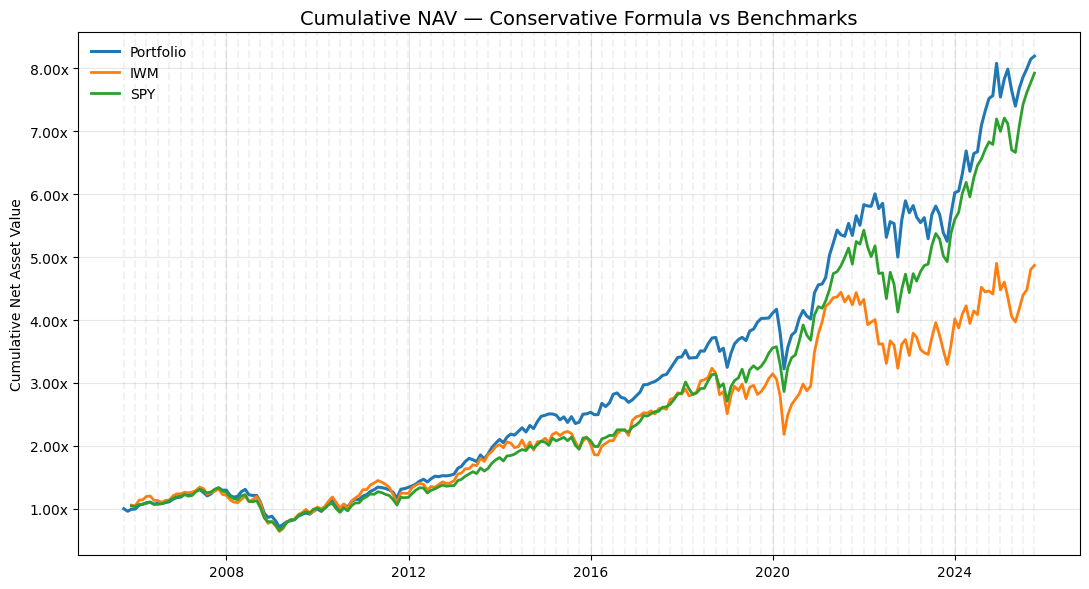

In [25]:
# --- Plot NAV comparison ---

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


fig, ax = plt.subplots(figsize=(11, 6))

for col in nav_comparison_full.columns:
    linewidth = 2.2 if col == "Portfolio" else 2
    ax.plot(nav_comparison_full.index, nav_comparison_full[col], label=col, linewidth=linewidth)

# Rebalance markers
for d in rebalance_dates:
    if nav_comparison_full.index.min() <= d <= nav_comparison_full.index.max():
        ax.axvline(d, color="gray", linestyle="--", alpha=0.1)

ax.set_title("Cumulative NAV — Conservative Formula vs Benchmarks", fontsize=14)
ax.set_ylabel("Cumulative Net Asset Value")
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.2f}x"))

ax.grid(True, alpha=0.3)
ax.legend(loc="best", frameon=False)

plt.tight_layout()
plt.show()

## Up/Down Capture Ratios

As an additional diagnostic, I evaluate how the **Conservative Formula portfolio** behaves relative to major benchmarks during up and down markets:

- **Up-Capture Ratio**  
  Shows how much of the benchmark’s positive returns the portfolio captures.  
  A value close to 100% means the portfolio rises nearly in line with the benchmark during up months.  

- **Down-Capture Ratio**  
  Measures how much of the benchmark’s losses the portfolio experiences in down months.  
  A value below 100% is desirable, as it indicates the portfolio loses less than the benchmark during market declines.  

This diagnostic complements earlier analyses and provides further insight into the portfolio’s risk profile.  
It highlights whether the Conservative Formula delivers on its promise of downside protection, beyond the standard metrics such as CAGR, volatility, Sharpe ratio, and maximum drawdown.

In [26]:
# --- Up/Down capture ratios vs Benchmarks ---

benchmark_returns = data_ctx["benchmark_navs"].pct_change().reindex(data_ctx["port_monthly_returns"].index)

def capture_ratios(portfolio: pd.Series, benchmark_returns: pd.Series):
    """Calculate up- and down-capture ratios of portfolio vs a benchmark."""
    
    portfolio = pd.Series(portfolio).dropna()
    benchmark_returns = pd.Series(benchmark_returns).reindex(portfolio.index).dropna()
    common_dates = portfolio.index.intersection(benchmark_returns.index)
    portfolio = portfolio.reindex(common_dates)
    benchmark_returns = benchmark_returns.reindex(common_dates)
    
    if portfolio.empty or benchmark_returns.empty:
        return np.nan, np.nan
    
    up = benchmark_returns > 0
    down = benchmark_returns < 0
    
    up_capture_ratio = (portfolio[up].mean() / benchmark_returns[up].mean()) if up.any() else np.nan
    down_capture_ratio = (portfolio[down].mean() / benchmark_returns[down].mean()) if down.any() else np.nan
    
    return up_capture_ratio, down_capture_ratio


portfolio_returns = data_ctx["port_monthly_returns"].copy()
capture_ratios_df = pd.DataFrame({
    "UpCapture":   [capture_ratios(portfolio_returns, benchmark_returns[t])[0] for t in benchmark_tickers],
    "DownCapture": [capture_ratios(portfolio_returns, benchmark_returns[t])[1] for t in benchmark_tickers],
}, index=[f"vs {t}" for t in benchmark_tickers])

print("Up/Down capture ratios - monthly averages ( <100% down-capture is desirable ):")
display(capture_ratios_df.applymap(lambda x: f"{x:.0%}" if pd.notna(x) else "NA"))

Up/Down capture ratios - monthly averages ( <100% down-capture is desirable ):


,UpCapture,DownCapture
vs SPY,88%,77%
vs IWM,72%,50%


## Risk Diagnostics

This step evaluates the risk profile of the **Conservative Formula portfolio** relative to major benchmarks.

1. **Volatility**  
   - The portfolio’s annualized volatility is compared against each benchmark.  
   - Portfolio volatility is constant across rows, while benchmark volatility varies by index.  

2. **Beta, Alpha, Correlation, R²**  
   - **Beta** measures the sensitivity of the portfolio to market movements.  
   - **Alpha** represents the portfolio’s annualized excess return after controlling for market exposure.  
   - **Correlation** and **R²** indicate how closely the portfolio co-moves with each benchmark.  

3. **Drawdown Analysis**  
   - Drawdown curves (cumulative loss from peak) are plotted for the portfolio and benchmarks.  
   - This highlights the magnitude and timing of losses, showing how the portfolio behaves during market downturns relative to broad indices.  

In [27]:
# --- Align Portfolio vs Benchmarks ---

portfolio_returns = data_ctx["port_monthly_returns"]
portfolio_nav_monthly = data_ctx["portfolio_nav_monthly"]

# Ensure 1-D Series
if isinstance(portfolio_returns, pd.DataFrame):
    portfolio_returns = portfolio_returns.iloc[:, 0]
if isinstance(portfolio_nav_monthly, pd.DataFrame):
    portfolio_nav_monthly = portfolio_nav_monthly.iloc[:, 0]

benchmark_navs = data_ctx["benchmark_navs"].copy()
benchmark_returns_monthly = benchmark_navs.pct_change().reindex(portfolio_returns.index).fillna(0.0)

common_dates = portfolio_returns.index.intersection(benchmark_returns_monthly.index)
portfolio_returns_aligned = portfolio_returns.reindex(common_dates).astype(float)
portfolio_nav_aligned = portfolio_nav_monthly.reindex(common_dates).astype(float)
benchmark_returns_monthly_aligned  = benchmark_returns_monthly.reindex(common_dates).astype(float)
benchmark_navs_aligned  = benchmark_navs.reindex(common_dates).astype(float)

In [28]:
# --- Risk metrics vs Benchmarks ---

def compute_risk_metrics(portfolio_returns, benchmark_returns):
    """Compute vol, beta, alpha, corr, R² for portfolio vs benchmark."""
    
    volatility_portfolio = float(portfolio_returns.std(ddof=0) * np.sqrt(12))
    volatility_benchmark = float(benchmark_returns.std(ddof=0) * np.sqrt(12))

    x = benchmark_returns.values
    y = portfolio_returns.values
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]

    if len(x) < 2:
        return {"Vol_Port": np.nan,
                "Vol_Bench": np.nan,
                "Beta": np.nan,
                "Alpha": np.nan,
                "Corr": np.nan,
                "R_Squared": np.nan}

    var_x = np.var(x, ddof=0)
    cov_xy = np.cov(y, x, ddof=0)[0, 1]
    beta = cov_xy / var_x if var_x != 0 else np.nan
    alpha_monthly = np.mean(y) - beta * np.mean(x) if np.isfinite(beta) else np.nan
    alpha_annual  = alpha_monthly * 12
    corr = np.corrcoef(y, x)[0, 1] if len(x) > 1 else np.nan
    r_squared = corr**2 if np.isfinite(corr) else np.nan

    return {
        "Vol_Port": volatility_portfolio,
        "Vol_Bench": volatility_benchmark,
        "Beta": beta,
        "Alpha": alpha_annual,
        "Corr": corr,
        "R_Squared": r_squared,
    }


risk_tbl = {}
for t in benchmark_tickers:
    risk_tbl[t] = compute_risk_metrics(portfolio_returns_aligned, benchmark_returns_monthly_aligned[t])

risk_df = pd.DataFrame(risk_tbl).T
display(risk_df.style.format({
    "Vol_Port": "{:.2%}",
    "Vol_Bench": "{:.2%}",
    "Beta": "{:.2f}",
    "Alpha": "{:.2%}",
    "Corr": "{:.2f}",
    "R_Squared": "{:.2f}",
}))

,Vol_Port,Vol_Bench,Beta,Alpha,Corr,R_Squared
SPY,14.56%,15.20%,0.85,1.95%,0.89,0.79
IWM,14.56%,20.05%,0.62,5.63%,0.85,0.72


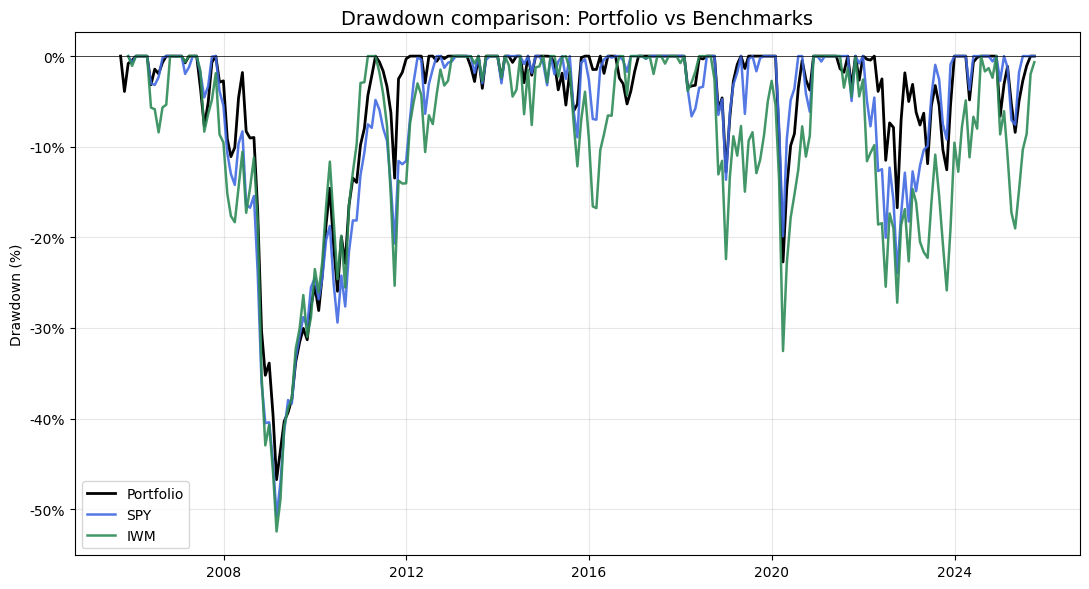

In [29]:
# --- Drawdown curves (Portfolio vs Benchmarks) ---

def compute_drawdown(nav: pd.Series) -> pd.Series:
    """Compute drawdown series from NAV."""
    peak = nav.cummax()
    return nav / peak - 1.0

colors = {
    "Portfolio": "black",
    "SPY": "royalblue",
    "IWM": "seagreen"
}

portfolio_drawdown = compute_drawdown(portfolio_nav_aligned)
benchmark_drawdowns = {
    ticker: compute_drawdown(benchmark_navs_aligned[ticker])
    for ticker in benchmark_tickers
}

plt.figure(figsize=(11, 6))

# Portfolio
plt.plot(
    portfolio_drawdown.index,
    portfolio_drawdown,
    label="Portfolio",
    lw=2,
    color=colors["Portfolio"]
)

# Benchmark
for ticker, dd in benchmark_drawdowns.items():
    plt.plot(
        dd.index,
        dd,
        label=ticker,
        lw=1.8,
        alpha=0.9,
        color=colors[ticker]
    )

plt.axhline(0, color="black", lw=0.5)
plt.title("Drawdown comparison: Portfolio vs Benchmarks", fontsize=14)
plt.ylabel("Drawdown (%)")
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0%}"))
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## Calendar-Year Analysis and Return Distributions

In this final step, I analyze the return profile of the **Conservative Formula portfolio** using complementary perspectives. These diagnostics cover the full 20-year backtest:

1. **Calendar-Year Returns (Portfolio)**  
   - Annual cumulative returns shown as a bar chart.  
   - Green bars = positive years, red bars = negative years.  
   - Provides an intuitive view of year-to-year consistency.

2. **Calendar-Year Returns (Portfolio vs Benchmarks)**  
   - A tabular comparison of yearly returns for the portfolio vs SPY and IWM.  
   - Conditional coloring highlights positive and negative years.  
   - Gives a side-by-side benchmark context for each year.

3. **Histogram of Monthly Returns (Portfolio vs Benchmarks)**  
   - Uses all monthly returns from the backtest period.  
   - Compares the portfolio with SPY and IWM.  
   - Shows the shape of the return distribution and whether the portfolio experiences fewer extreme losses.

Together, these visuals complement the NAV and drawdown charts by focusing on the **consistency and distribution** of returns, offering both statistical and intuitive insight.

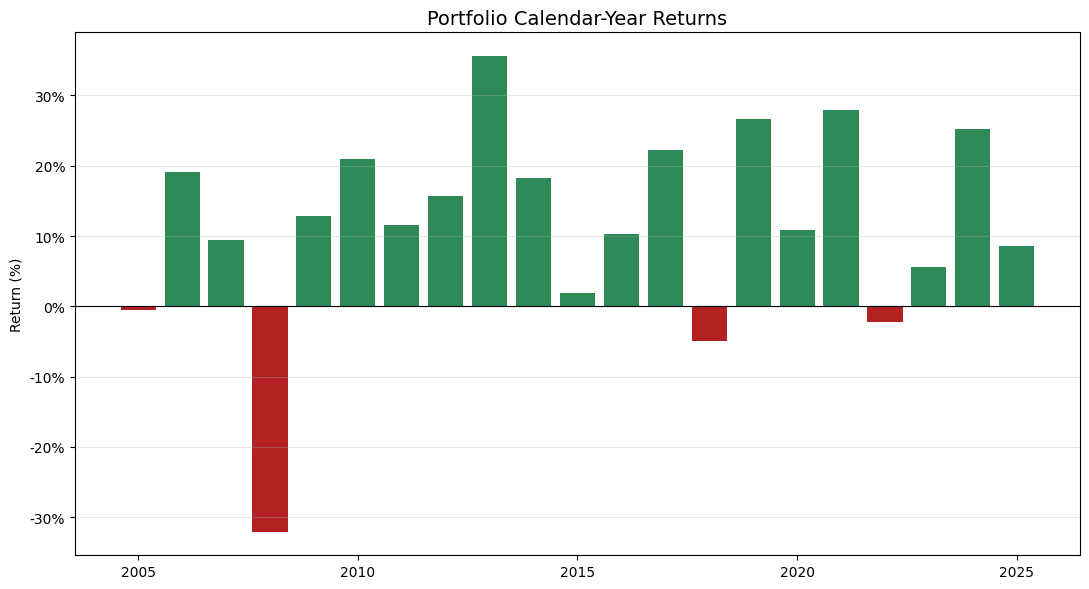

In [30]:
# --- Calendar-Year Returns (Portfolio) ---

calendar_year_returns = (1 + portfolio_returns).groupby(portfolio_returns.index.year).prod() - 1

plt.figure(figsize=(11,6))
bar_colors = calendar_year_returns.apply(lambda x: "seagreen" if x > 0 else "firebrick")

plt.bar(calendar_year_returns.index, calendar_year_returns.values, color=bar_colors)
plt.axhline(0, color="black", linewidth=0.8)
plt.title("Portfolio Calendar-Year Returns", fontsize=14)
plt.ylabel("Return (%)")

from matplotlib.ticker import FuncFormatter
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0%}"))

plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

In [31]:
# --- Calendar-Year Returns (Portfolio vs Benchmarks) ---

benchmark_returns_monthly = data_ctx["benchmark_navs"].pct_change().reindex(portfolio_returns.index)

annual_returns = pd.DataFrame({
    "Portfolio": (1 + portfolio_returns).groupby(portfolio_returns.index.year).prod() - 1,
    "SPY": (1 + benchmark_returns_monthly["SPY"]).groupby(portfolio_returns.index.year).prod() - 1,
    "IWM": (1 + benchmark_returns_monthly["IWM"]).groupby(portfolio_returns.index.year).prod() - 1,
})

def color_scale(val):
    color = "seagreen" if val > 0 else "firebrick"
    return f"color: {color}; font-weight: bold"

display(annual_returns.style.format("{:.2%}").applymap(color_scale))

,Portfolio,SPY,IWM
Date,,,
2005,-0.47%,-0.72%,-1.08%
2006,19.06%,15.81%,18.23%
2007,9.39%,5.17%,-1.70%
2008,-32.02%,-36.97%,-34.42%
2009,12.84%,26.70%,28.94%
2010,20.89%,15.07%,26.86%
2011,11.54%,1.79%,-4.46%
2012,15.67%,15.90%,16.27%
2013,35.59%,32.53%,39.36%


In [32]:
# --- Cumulative Returns (Portfolio vs Benchmarks) ---

cumulative_returns = (1 + annual_returns).prod() - 1
display(cumulative_returns.to_frame("Total Return").style.format("{:.2%}"))

,Total Return
Portfolio,719.46%
SPY,659.04%
IWM,360.37%


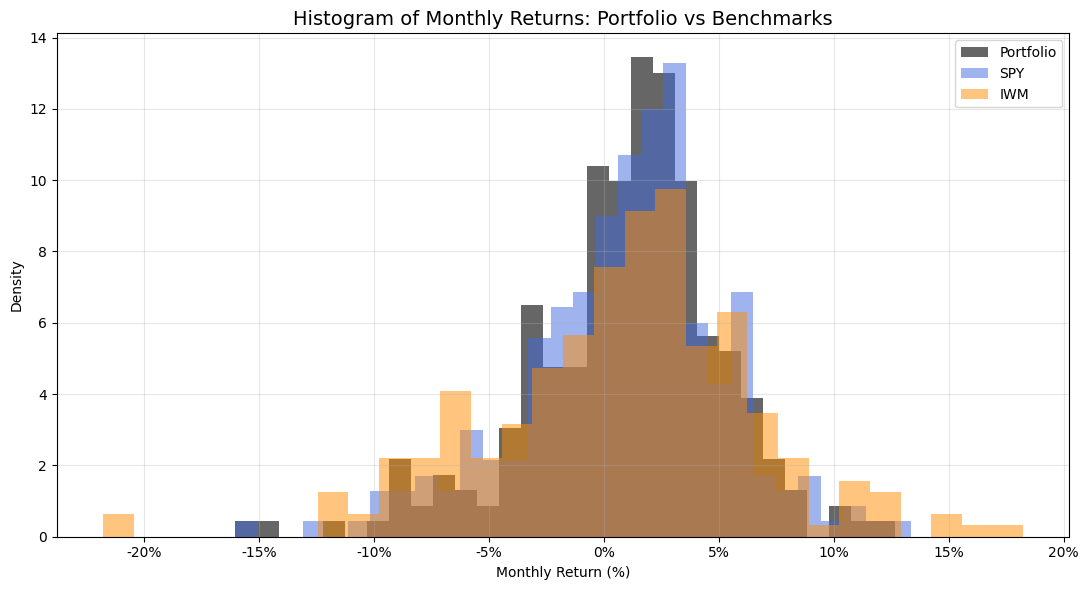

In [33]:
# --- Histogram of Monthly Returns (Portfolio vs Benchmarks) ---

benchmark_returns_monthly = data_ctx["benchmark_navs"].pct_change().reindex(portfolio_returns.index)

plt.figure(figsize=(11,6))

plt.hist(
    portfolio_returns.dropna(),
    bins=30,
    alpha=0.6,
    label="Portfolio",
    color="black",
    density=True
)
for ticker, color in zip(benchmark_tickers, ["royalblue", "darkorange", "seagreen"]):
    plt.hist(
        benchmark_returns_monthly[ticker].dropna(),
        bins=30,
        alpha=0.5,
        label=ticker,
        color=color,
        density=True
    )

plt.title("Histogram of Monthly Returns: Portfolio vs Benchmarks", fontsize=14)
plt.xlabel("Monthly Return (%)")
plt.ylabel("Density")

plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.0%}"))

plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## Summary

In this project, I implemented and analyzed the **Conservative Formula** - a quantitative equity strategy developed by Pim van Vliet and David Blitz (Robeco, 2018).  
The strategy combines three factors to identify conservative stocks:

- **Momentum (12-1)** - past one-year return, skipping the most recent month.  
- **Volatility** - 36-month rolling standard deviation of returns.  
- **Net Payout Yield (NPY)** - approximated here with trailing 12-month dividend yield.  

### Portfolio Construction
- Start from the S&P 500 universe.
- Each quarter, keep the **lowest-volatility stocks**.
- Rank them by momentum and payout yield, average the two ranks.
- Select the **top 100 stocks** and assign **equal weights (1/100 each)**.

### Key Backtest Results (20 years, monthly data)
- **Total Return:** 710.81%  
- **Annualized CAGR:** 10.98%  
- **Sharpe Ratio:** 0.79  
- **Max Drawdown:** -46.96% (from 2007-10-31 to 2009-02-28)  

### Benchmark Comparison
- Outperformed the **S&P 500 (SPY)** in cumulative returns.  
- Achieved lower volatility and smaller drawdowns than **Russell 2000 (IWM)**.  

### Conclusion
The Conservative Formula portfolio outperformed both SPY and IWM over the backtest period.  
Compared to the S&P 500 (SPY), it delivered higher long-term returns with slightly lower volatility and drawdowns.  
Against the small-cap Russell 2000 (IWM), the strategy showed even stronger results, combining superior cumulative performance with significantly lower risk.  
This confirms the defensive profile of the strategy: it captures upside in rising markets while providing better resilience during downturns, resulting in attractive risk-adjusted returns.  

---

⚠️ **Disclaimer:** This project is for educational and research purposes only.  
It does not constitute financial advice or an investment recommendation.  

**Source:** Strategy concept based on Robeco’s *Conservative Formula* (Pim van Vliet & David Blitz)  
**Working Paper:** [SSRN link](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3145152)
